#Procesamiento de datos del Visound
Esta rutina procesa y visualiza los datos que se generan con el programa visound.
La app va subiendo los datos a un servidor. Este servidor corre en una virtual machine en la compu de casa sobre un ubuntu server en el que instale un json-server. 
Esta rutina descarga los datos del servidor en su ultima version y los procesa para hacer una visualizacion de la actividad de los usuarios en forma grafica (un timeline de la actividad)

In [1]:
%matplotlib inline
from IPython import embed
from IPython.display import display
#from Scripts import *
from graficos import *
from load import *
from DownloadFile import *

# Recoleccion de datos

Bajamos la ultima version del archivo de internet y nos fijamos de guardar la version anterior con una marca temporal

In [6]:
DownloadFile ()

In [2]:
touchs, sounds = load()

Usuario: Usr0 sounds: 291
session: 1445291722247 sounds: 22
nivel: 1445291724663 sounds: 22
trial: 1445291724739 sounds: 22
trial: 1445291726042 sounds: 0
trial: 1445291742556 sounds: 0
trial: 1445291748637 sounds: 0
trial: 1445291752548 sounds: 0
trial: 1445291773209 sounds: 0
trial: 1445291779023 sounds: 0
trial: 1445291796791 sounds: 0
session: 1445291927377 sounds: 269
nivel: 1445291930477 sounds: 55
trial: 1445291930736 sounds: 0
trial: 1445291936706 sounds: 0
trial: 1445291942339 sounds: 0
trial: 1445291955726 sounds: 0
trial: 1445291967564 sounds: 0
trial: 1445291971966 sounds: 0
trial: 1445291983970 sounds: 0
trial: 1445291995139 sounds: 0
trial: 1445291998287 sounds: 0
trial: 1445292001862 sounds: 0
trial: 1445292007068 sounds: 0
trial: 1445292009950 sounds: 0
trial: 1445292014809 sounds: 0
trial: 1445292019930 sounds: 0
trial: 1445292027008 sounds: 0
trial: 1445292033365 sounds: 0
trial: 1445292041118 sounds: 0
trial: 1445292045183 sounds: 0
trial: 1445292048972 sounds: 0
tri

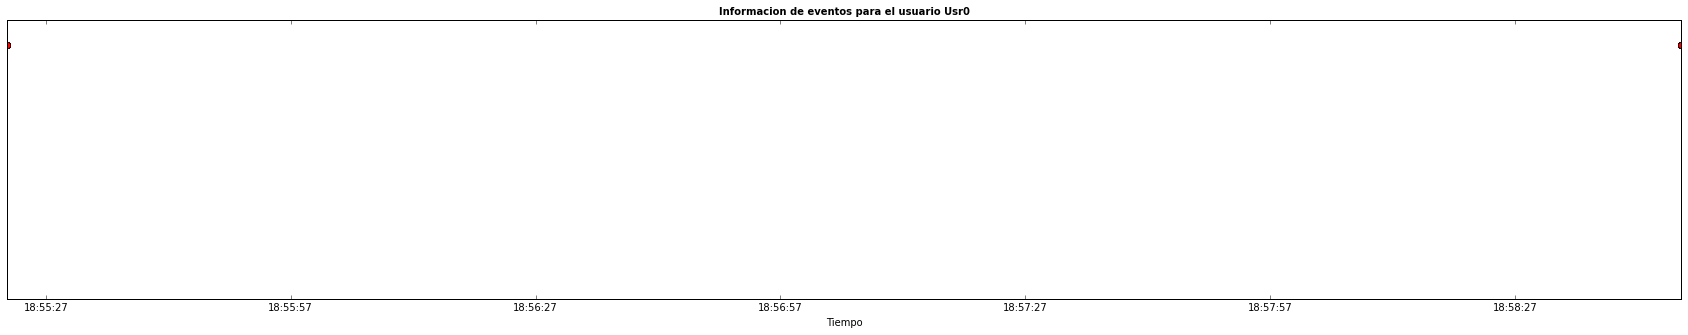

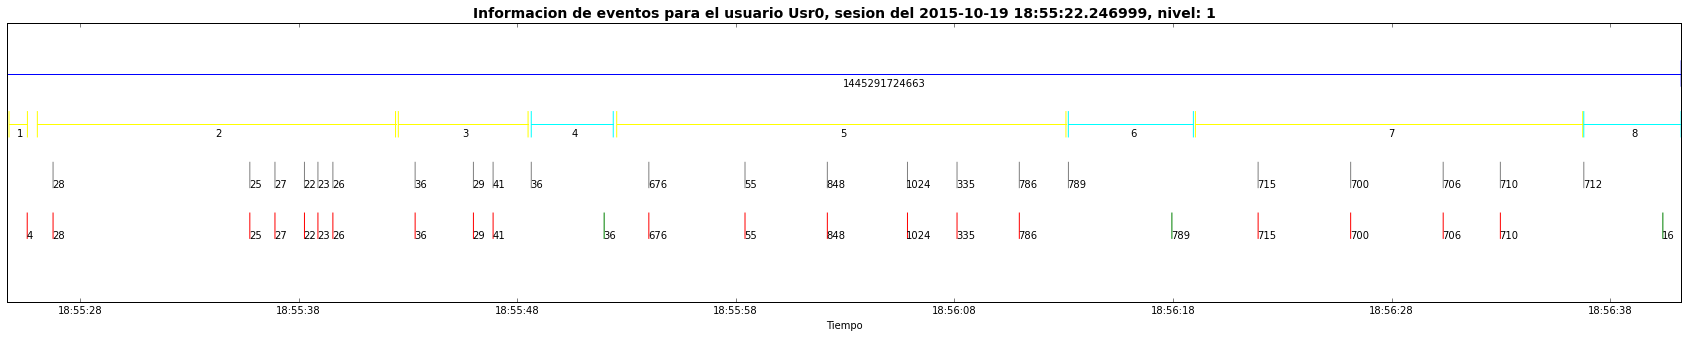

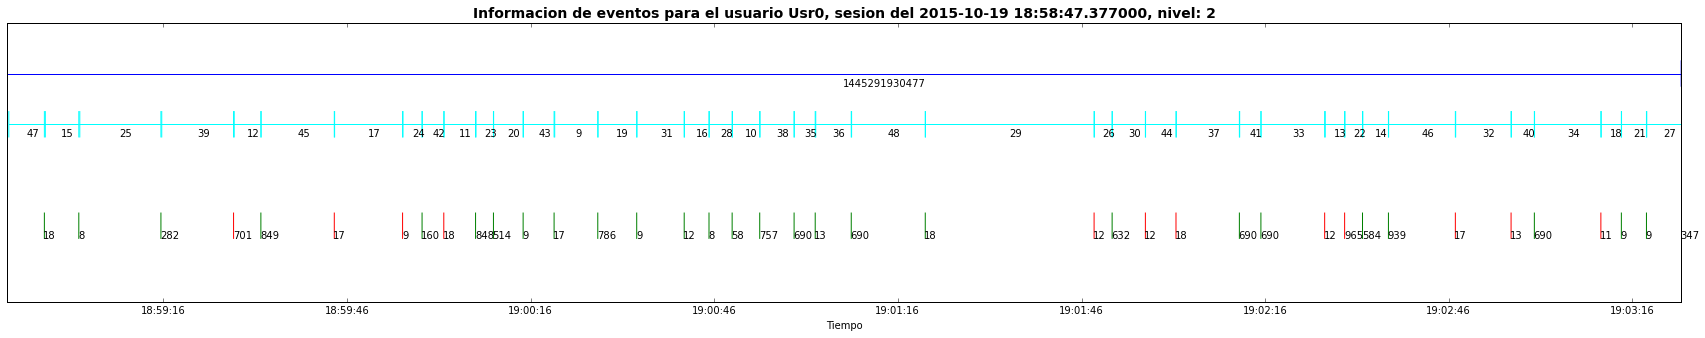

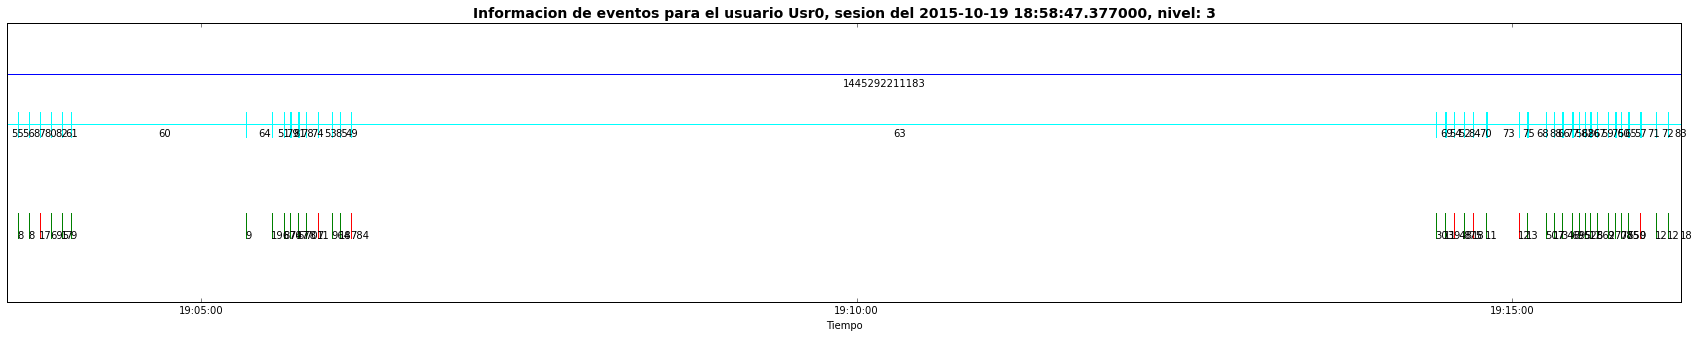

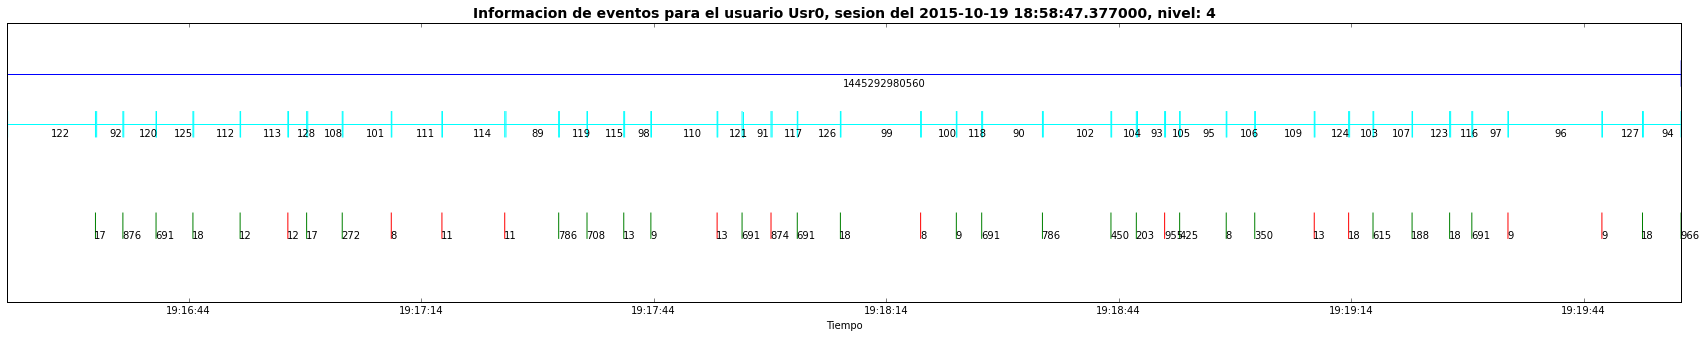

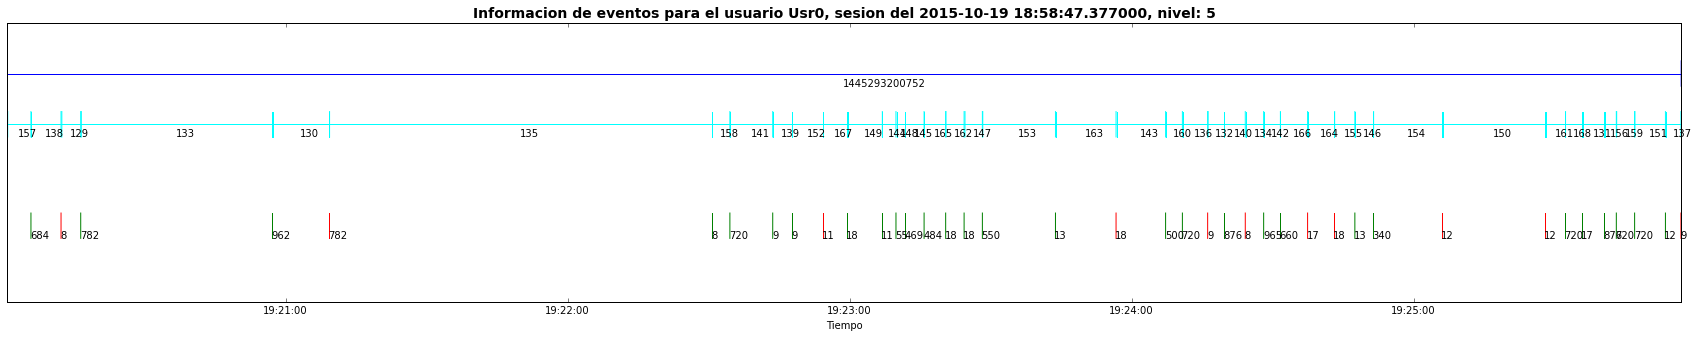

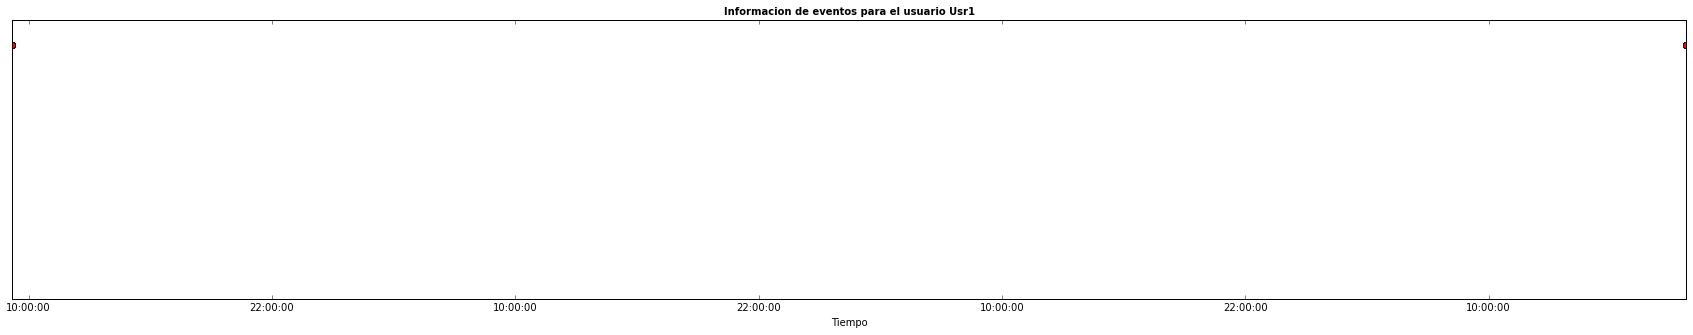

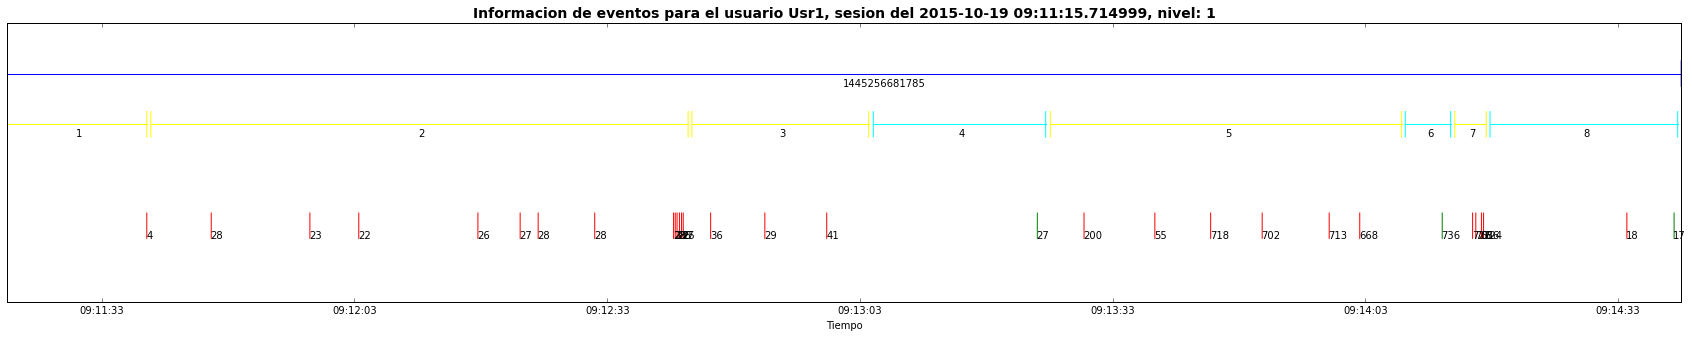

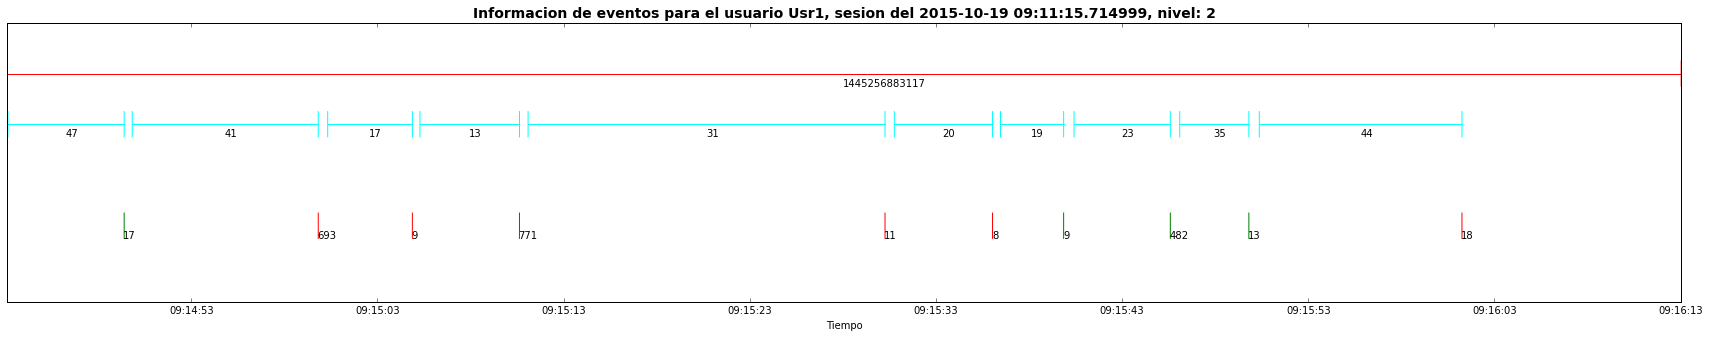

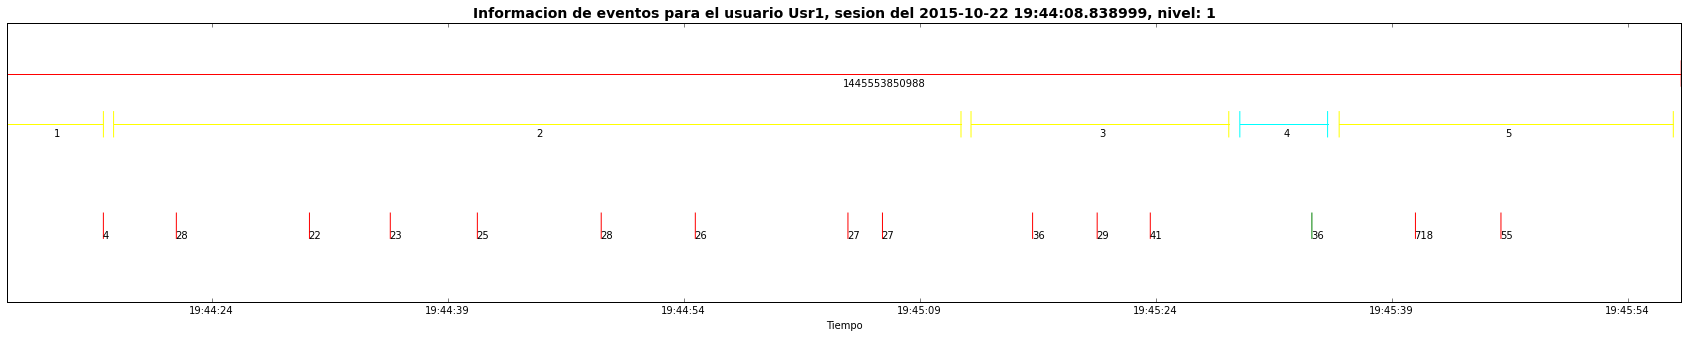

In [46]:


import matplotlib.pyplot as plt
import numpy as np
import datetime

juntar = False # Si es true, junta todos los levels de una misma sesion, sino separa por level

for usuario in touchs['Alias'].unique():
    # Genera el plot
    fig = plt.figure(figsize=(30,5))

    ax = fig.add_subplot(111)
    ax.set_title('Informacion de eventos para el usuario {}'.format(usuario), fontsize=10, fontweight='bold')
    ax.set_xlabel('Tiempo')
    ax.set_ylabel('')
    ax.get_yaxis().set_ticks([])
    ax.set_ylim([0,11])



    # Procesa la info para graficar las sesiones del usuario
    fechas = touchs[touchs['Alias']==usuario]['sessionInstance']
    fechasFormateadas = [fechaLocal(fecha) for fecha in fechas]
    altura = np.ones(fechas.size)*10
    ax.plot(fechasFormateadas,altura,'ro')

    touchsUsuario = touchs[touchs['Alias'] == usuario]
    soundsUsuario = sounds[sounds['Alias'] == usuario]
    print ('Usuario: '+str(usuario)+' sounds: '+str(len(soundsUsuario)))
    
    # ahora para este usuario va a hacer un grafico por sesion
    for session in touchsUsuario['sessionInstance'].unique():

        #Carga los touchs de cada session
        touchsSession = touchsUsuario[touchsUsuario['sessionInstance']==session]
        soundsSession = soundsUsuario[soundsUsuario['sessionInstance']==session]
        print ('session: '+str(session)+' sounds: '+str(len(soundsSession)))
        
        if juntar: #Crea un grafico nuevo si esta configurado asi
            if touchsSession.size > 0:
                # Genera el plot si se va a usar
                fig = plt.figure(figsize=(30,5))
                ax = fig.add_subplot(111)
                ax.set_title('Informacion de eventos para el usuario '+str(usuario)+' sesion del '+str(fechaLocal(touchSession)), fontsize=14, fontweight='bold')
                ax.set_xlabel('Tiempo')
                ax.set_ylabel('')
                ax.get_yaxis().set_ticks([])
                ax.set_ylim([0,11])

        # Procesa la info de los levels
        for level in touchsSession['levelInstance'].unique():

            touchsLevel = touchsSession[touchsSession['levelInstance']==level]
            soundsLevel = soundsSession[soundsSession['levelInstance']==level]
            print ('nivel: '+str(level)+' sounds: '+str(len(soundsLevel)))
            levelInfo = touchsLevel.iloc[0]
                                    
            if not juntar: #Crea un grafico nuevo si esta configurado asi
                # Genera el plot si se va a usar
                fig = plt.figure(figsize=(30,5))
                ax = fig.add_subplot(111)
                ax.set_title('Informacion de eventos para el usuario '+str(usuario)+', sesion del '+str(fechaLocal(session))+', nivel: '+str(levelInfo['levelId']), fontsize=14, fontweight='bold')
                ax.set_xlabel('Tiempo')
                ax.set_ylabel('')
                ax.get_yaxis().set_ticks([])
                ax.set_ylim([0,11])

            # Configura el color segun este completado o no el nivel
            if levelInfo['levelCompleted'] == True:
                color = 'blue'
            else:
                color = 'red'
                
            # Grafica el segmento principal
            x = [fechaLocal(levelInfo['timeLevelStarts']),fechaLocal(levelInfo['timeLevelExit'])]
            y = [9,9]
            ax.plot(x,y,color=color)
            # Grafica dos bordes para remarcar los inicios y los finales
            ax.plot([fechaLocal(levelInfo['timeLevelStarts']-0.01),fechaLocal(levelInfo['timeLevelStarts']+0.01)],[y[0]+0.5,y[0]-0.5],color=color)
            ax.plot([fechaLocal(levelInfo['timeLevelExit']-0.01),fechaLocal(levelInfo['timeLevelExit']+0.01)],[y[0]+0.5,y[0]-0.5],color=color)
            
            # Agrega el id del nivel
            xCenter = fechaLocal((levelInfo['timeLevelStarts']+levelInfo['timeLevelExit'])/2)
            ax.text(xCenter, 8.5, levelInfo['levelInstance'])

            
            # Procesa la info de los trials del level en cuestion
            for trial in touchsLevel['trialInstance'].unique():
                
                touchsTrial = touchsLevel[touchsLevel['trialInstance']==trial]
                soundsTrial = soundsLevel[soundsLevel['trialInstance']==trial]
                print ('trial: '+str(trial)+' sounds: '+str(len(soundsTrial)))
                # SEGUIR! Por alguna razon no esta andando bien este filtro!
                trialInfo = touchsTrial.iloc[0]
                
                # Configura el color segun el tipo de trial
                if trialInfo['tipoDeTrial'] == 'ENTRENAMIENTO':
                    color = 'yellow'
                else:
                    color = 'cyan'
                    
                # Grafica el segmento principal
                x = [fechaLocal(trialInfo['timeTrialStart']),fechaLocal(trialInfo['timeTrialExit'])]
                y = [7,7]
                ax.plot(x,y,color=color)
                # Grafica dos bordes para remarcar los inicios y los finales
                ax.plot([fechaLocal(trialInfo['timeTrialStart']-0.01),fechaLocal(trialInfo['timeTrialStart']+0.01)],[y[0]+0.5,y[0]-0.5],color=color)
                ax.plot([fechaLocal(trialInfo['timeTrialExit']-0.01),fechaLocal(trialInfo['timeTrialExit']+0.01)],[y[0]+0.5,y[0]-0.5],color=color)
                # Agrega el id del trial
                xCenter = fechaLocal ((trialInfo['timeTrialStart']+trialInfo['timeTrialExit'])/2)
                ax.text(xCenter, 6.5, trialInfo['trialId'])

                # Procesa la info de los touchs del trial en cuestion 
                for touchInstance in touchsTrial['touchInstance'].unique():
                    touch = touchsTrial[touchsTrial['touchInstance']==touchInstance]
                    touch = touch.iloc[0]
                    
                    # Configura el color segun sea un acierto o no
                    if touch['isTrue'] == True: # Ojo que aca un Nan es un false!
                        color = 'green'
                    else:
                        color = 'red'

                    y = [3,3]
                    # Grafica el segmento cuasivertical
                    ax.plot([fechaLocal(touch['touchInstance']-0.01),fechaLocal(touch['touchInstance']+0.01)],[y[0]+0.5,y[0]-0.5],color=color)
                    # Agrega el id del elemento tocado
                    xCenter = fechaLocal(touch['touchInstance']+0.3)
                    ax.text(xCenter, 2.5, touch['idResourceTouched']['id'])
                    
                    
                # Procesa los sounds en cada trial
                for soundInstance in soundsTrial['soundInstance'].unique():
                    
                    sound = soundsTrial[soundsTrial['soundInstance']==soundInstance]
                    sound = sound.iloc[0]
                    
                    # Configura el color
                    color = 'gray'
                    y = [5,5]
                    # Grafica el segmento cuasivertical
                    ax.plot([fechaLocal(soundInstance-0.01),fechaLocal(soundInstance+0.01)],[y[0]+0.5,y[0]-0.5],color=color)
                    # Agrega el id del elemento tocado
                    xCenter = fechaLocal(soundInstance+0.3)
                    ax.text(xCenter, 4.5, sound['soundSourceId']['id'])
                    
                

In [ ]:
# Procesa los sounds en cada trial
                soundsTrial = sounds[sounds['trialInstance']==trial['trialInstance']]
                for index, sound in soundsTrial.iterrows():

                    # Configura el color
                    color = 'gray'
                    y = [5,5]
                    # Grafica el segmento cuasivertical
                    ax.plot([datetime.datetime.fromtimestamp(sound['soundInstance']/1000-0.01),datetime.datetime.fromtimestamp(sound['soundInstance']/1000+0.01)],[y[0]+0.5,y[0]-0.5],color=color)
                    # Agrega el id del elemento tocado
                    xCenter = datetime.datetime.fromtimestamp (sound['soundInstance']/1000+0.3)
                    ax.text(xCenter, 4.5, sound['soundId']['id'])


# Con los datos ya cargados graficamos los resultados

La idea de esta seccion es hacer un analisis visual de los datos. Para eso vamos a armar un timeline donde vamos a mostrar con dibujos (lines, rectangulos, etc) lo que va pasando en el juego en funcion de diferentes criterios. Para un usuario cuando jugo, en usa sesion que paso, etc.

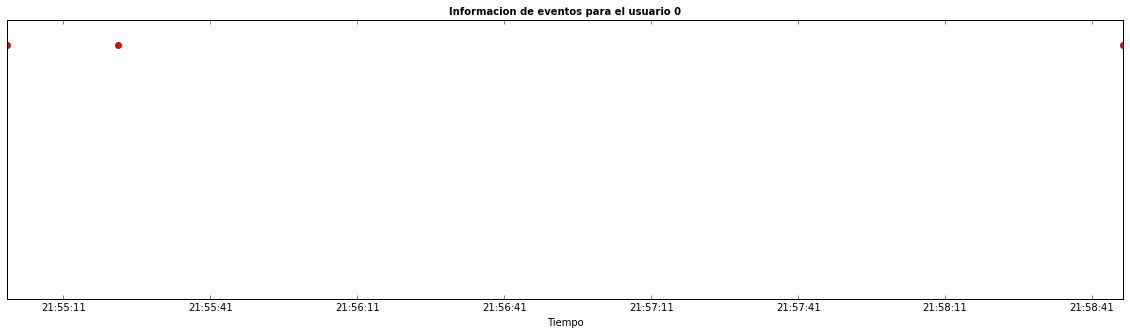

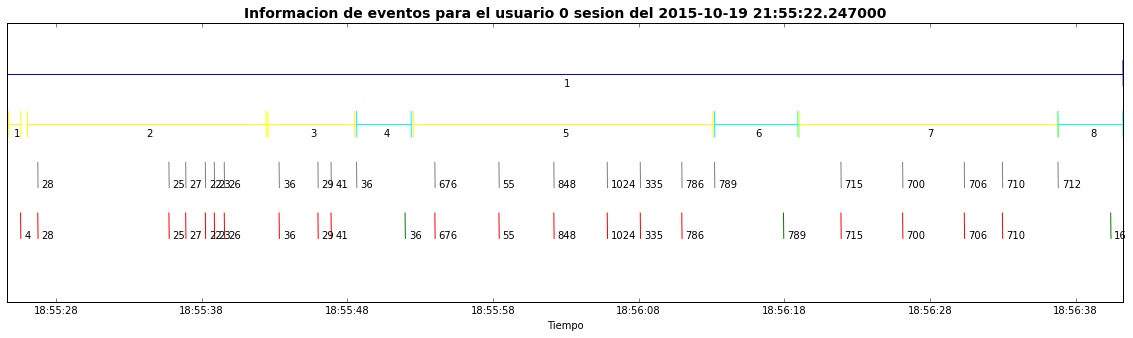

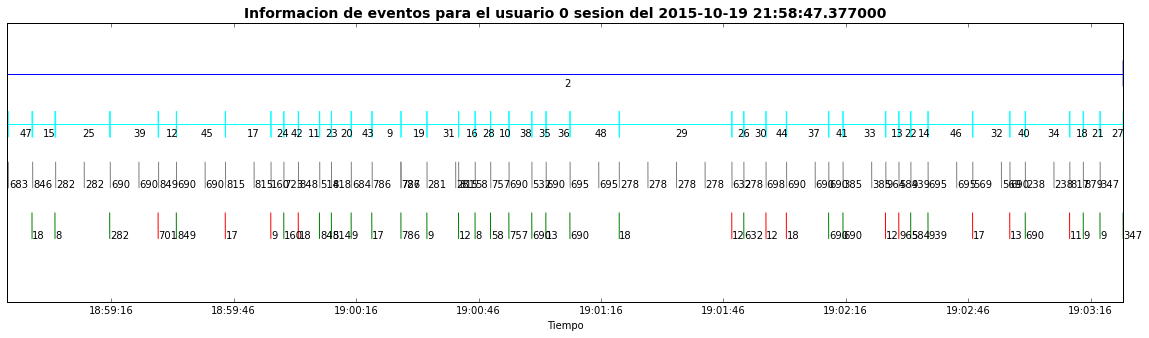

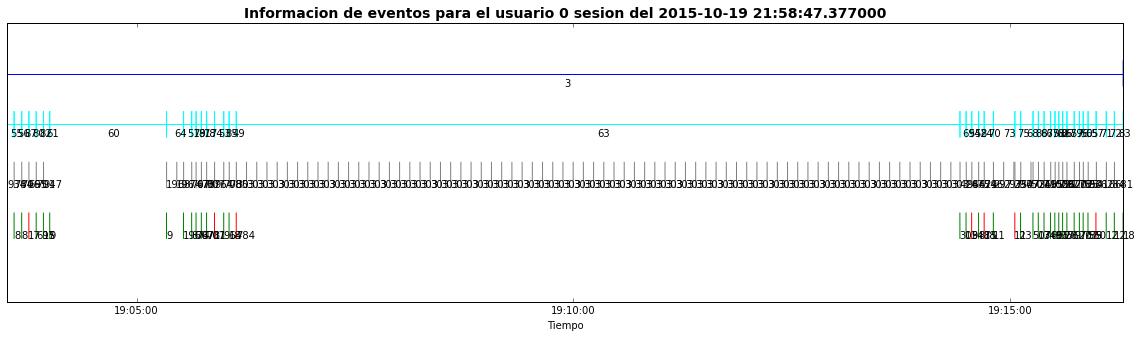

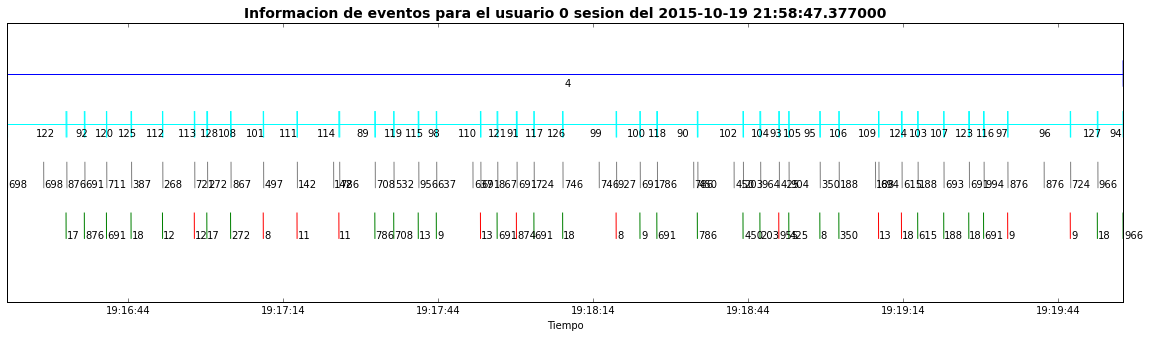

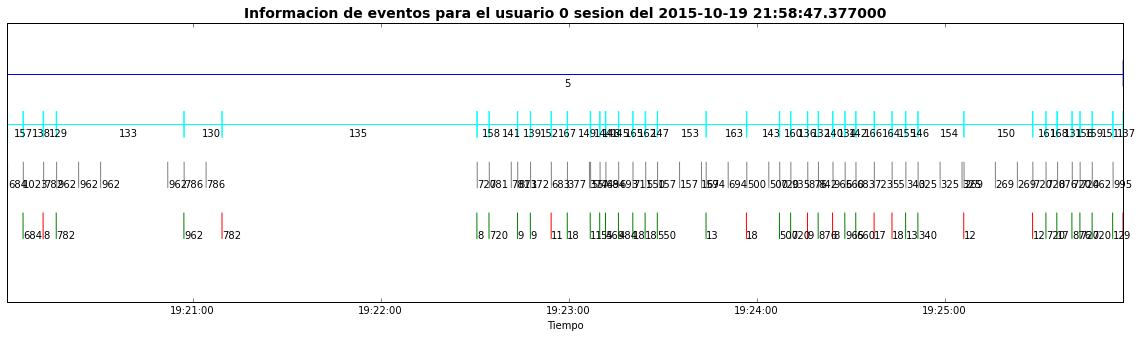

In [4]:
graficarTimeline (touchs, sounds)

# Cosas de estadistica

En esta seccion se va a hacer un procesamiento estidistico de los datos para evaluar los resultados en funcion de diferentes parametros.


Se analizara las estadisticas del usuario 0:
Cantidad de veces que se logueo el usuario: 3
Fechas:
2015-10-19 18:54:59.523999
2015-10-19 18:55:22.246999
2015-10-19 18:58:47.377000

Se analizara la sesion del 2015-10-19 18:54:59.523999
Numero de niveles jugados en esta sesion: 0

Se analizara la sesion del 2015-10-19 18:55:22.246999
Numero de niveles jugados en esta sesion: 1

Detalles del nivel: 1
Titulo del nivel: Tutorial
Horario de juego: 2015-10-19 18:55:24.663000
Duracion del nivel: 1.2764 minutos

Detalle de los trials del nivel 1:


0



Se analizara la sesion del 2015-10-19 18:58:47.377000
Numero de niveles jugados en esta sesion: 4

Detalles del nivel: 2
Titulo del nivel: Test
Horario de juego: 2015-10-19 18:58:50.476999
Duracion del nivel: 4.5582 minutos

Detalle de los trials del nivel 2:


0



Detalles del nivel: 3
Titulo del nivel: Test
Horario de juego: 2015-10-19 19:03:31.183000
Duracion del nivel: 12.771 minutos

Detalle de los trials del nivel 3:


0



Detalles del nivel: 4
Titulo del nivel: Test
Horario de juego: 2015-10-19 19:16:20.559999
Duracion del nivel: 3.6006 minutos

Detalle de los trials del nivel 4:


0



Detalles del nivel: 5
Titulo del nivel: Test
Horario de juego: 2015-10-19 19:20:00.752000
Duracion del nivel: 5.935 minutos

Detalle de los trials del nivel 5:


0



Se analizara las estadisticas del usuario 1:
Cantidad de veces que se logueo el usuario: 3
Fechas:
2015-10-13 20:02:17.744999
2015-10-19 09:11:15.714999
2015-10-22 19:44:08.838999

Se analizara la sesion del 2015-10-13 20:02:17.744999
Numero de niveles jugados en esta sesion: 1

Detalles del nivel: 2
Titulo del nivel: Test Inicial
Horario de juego: 2015-10-13 20:02:22.674000
Duracion del nivel:  minutos

Detalle de los trials del nivel 2:


KeyError: 'the label [0] is not in the [index]'

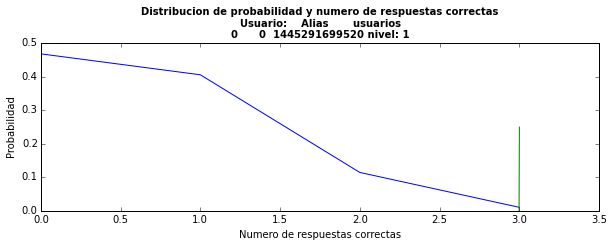

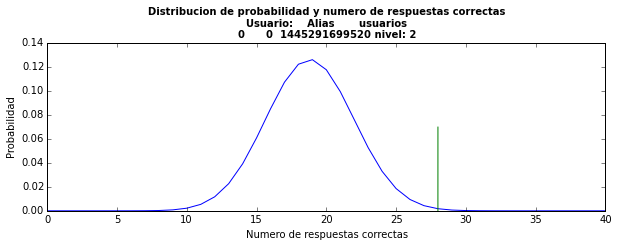

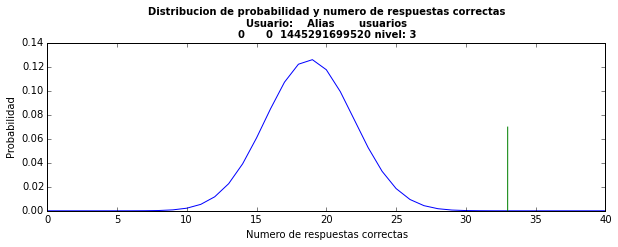

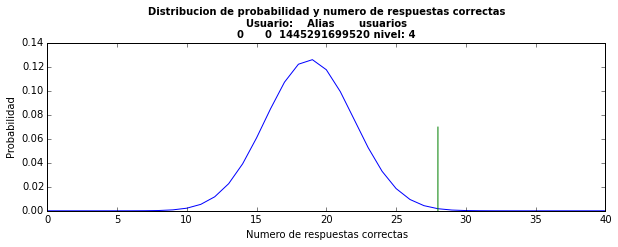

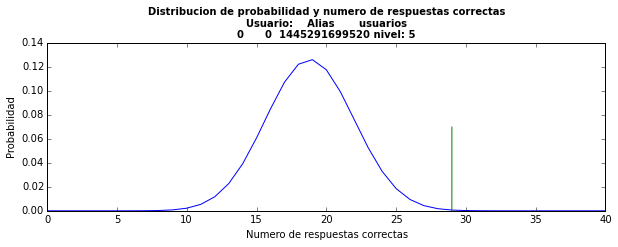

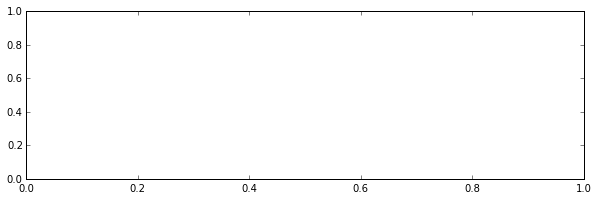

In [21]:
for index, usuario in data['usuarios'].iterrows():
    analizarUsuario(usuario,data)

In [6]:
def distribucionDeProbabilidadRandom (histograma):
    
    import math
    
    distribuciones = [0] * len(histograma)
    # Primer calculamos la distribucion de probabilidad para cada subset de trials con identicas opciones de respuesta
    for i in range(len(histograma)):
        N = i+1 # Representa el numero de opciones posibles a elegir
        m = histograma[i] # Representa el numero de trials que se contestan en el subset
        subset_N = [0] * (m+1) # Sumamos el 1 porque si hay cero elementos igual hay una opcion, las opciones son el cerrado [0,numero de trials]
        p = 1/N # es la probabilidad de acertar entre la cantidad de opciones presentadas (que es i+1)
        if m==0:
            distribuciones[i] = [1]
        else:
            for j in range(m+1): # j representa la cantidad de opciones correctas
                # Calculamos la probabilidad de obtener una cantidad de respuestas correctas j, cuando cada trial tiene N opciones
                Pj = math.pow(p,j)*math.pow(1-p,m-j)*math.factorial(m)/(math.factorial(j)*math.factorial(m-j))
                subset_N[j] = Pj
            distribuciones[i] = subset_N
    # Aqui ya esta la distribucion de cada subset. ahora hay que calcular la distribucion global, para eso hay que combinar las dritribciones
    
    # La idea es que si tenemos dos distribuciones N1 y N2 cada uno con J y J' elementos (donde J y J' es el numero de trials maximo que hay con N1 y N2 opciones)
    # y j1 representa la probabilidad de responder j1 veces bien en los trials de N1 opciones y j2 representar la probabilidad de responder j2 veces bien
    # en los trials de N2 opciones, 
    # entonces la suma de todos los productos cuyos indices j1 +j2 de j3 es la probabilidad de responde j3 veces bien entre los trials de N1 y N2 opciones 
    combinado = [1] # Inicialmente hay probabilidad 1 de tener 0 bien
    for N in range(len(distribuciones)):
        combinadoNew = [0] * (sum(histograma)+1) # Armo una combinacion que este vacia
        for i_1 in range(len(combinado)):
            if combinado[i_1] != 0: # Esto tiene dos razones, una es evitar cuentas innecesarias. La otra mas importante es evitar que aplique el contador hasta el final y que la suma de los dos contadores de mas que el numero de trials maximos posible, lo que genera un error
                for i_2 in range(len(distribuciones[N])):
                    combinadoNew[i_1+i_2] = combinadoNew[i_1+i_2] + combinado[i_1]*distribuciones[N][i_2] #Acumulo todos las combinaciones
        combinado = combinadoNew
    
    return combinado



def analizarSesion (sesion, data):
    
    import matplotlib.pyplot as plt
    
    #Carga los datos
    levels=data['levels']
    trials=data['trials']
    touchs=data['touchs']
    usuarios=data['usuarios']
    
    print ('Se analizara la sesion del '+ str(fechaLocal(sesion['id'])))
    levelsSesion = levels[levels['sessionId']==sesion['id']]

    print ('Numero de niveles jugados en esta sesion: '+str(len(levelsSesion.index)))
    print ('')
    
    for index, level in levelsSesion.iterrows():
        print ('Detalles del nivel: '+str(level['levelId']))
        print ('Titulo del nivel: ' + level['levelTitle'])
        print ('Horario de juego: ' + str(fechaLocal(level['levelInstance'])))
        print ('Duracion del nivel: ' + str((level['timeExit']-level['timeStarts'])/1000 * 1/60)[:-12] + ' minutos')
        
        if not level['levelCompleted']:
            print ('Nivel incompleto')
        
        print ('')
        print ('Detalle de los trials del nivel '+str(level['levelId'])+':')
        trialsLevel = trials[trials['levelInstance']==level['levelInstance']]
        trialsLevelTest = trialsLevel[trialsLevel['tipoDeTrial']=='TEST']
        histograma = makeHistogramaTrials(trialsLevelTest)
        # print ('Histograma de numero de opciones a responder para el nivel: ' + str(histograma))
        distribucion = distribucionDeProbabilidadRandom(histograma)
        # Hacemos un plot con los datos y el resultado
        fig = plt.figure(figsize=(10,3))
        ax = fig.add_subplot(111)
        usuario = usuarios[usuarios['usuarios']==level['idUser']]
        display(usuario.loc[0,'Alias'])
        title = 'Distribucion de probabilidad y numero de respuestas correctas \n' + 'Usuario: '+str(usuario) + ' nivel: ' + str(level['levelId'])
        ax.set_title(title, fontsize=10, fontweight='bold')
        ax.set_xlabel('Numero de respuestas correctas')
        ax.set_ylabel('Probabilidad')
        x = range(len(distribucion))
        y = distribucion
        ax.plot(x,y)
        # Ahora agregamos la marca del numero obtenido, para eso primero hay que calcularlo
        touchsLevel = touchs[touchs['levelInstance']==level['levelInstance']]
        aciertos = 0
        for index, touch in touchsLevel.iterrows():
            if touch['tipoDeTrial'] == 'TEST':
                if touch['isTrue'] == True:
                    aciertos = aciertos + 1
        x=[aciertos-0.001,aciertos+0.001]        
        y=[0,ax.get_ylim()[1]/2]
        color = 'green'
        ax.plot(x,y,color)
        print ('')
        print ('')

def analizarUsuario (usuario, data):
    #Carga los datos necesarios
    sessions = data['sessions']
    
    print ('Se analizara las estadisticas del usuario '+ str(usuario['Alias'])+':')
    sesionesUsuario = sessions[sessions['userID']==usuario['usuarios']]
    
    print ('Cantidad de veces que se logueo el usuario: '+str(len(sesionesUsuario.index)))
    print ('Fechas:')
    
    for fecha in sesionesUsuario['id']:
        print (str(fechaLocal(fecha)))
    
    print ('')
    
    for index, session in sesionesUsuario.iterrows():
        analizarSesion(session,data)

def fechaLocal (millisec):
    import datetime
    
    return datetime.datetime.fromtimestamp(millisec/1000)

def makeHistogramaTrials (trials):
    
    #
    # Esta rutina encuentra un histograma de frecuencia de cantidad de opciones para elegir respuesta.
    # La idea es que con estos datos despues se puede calcular como es una distribucion de respuestas random y asi saber cual es la probabilidad de hipotesis nula
    # El histograma tiene que tener un largo igual al maximo de opciones posibles +1 porque el en casillero cero se guarda la cantidad con cero opciones
    # Esto no tiene mucho sentido conceptual aca pero si despues para las cuentas
    #
    
    histograma = []
    for index, trial in trials.iterrows():
        # REVISAR esto sirve para la version vieja de datos, en el futuro hay que cambiarlo para que busque en el json bien donde corresponde
        if len(trial['resourcesIdSort']) > len (histograma): 
            ext = [0] * (len(trial['resourcesIdSort'])-len (histograma))
            histograma.extend(ext)
        histograma[len(trial['resourcesIdSort'])-1] = histograma[len(trial['resourcesIdSort'])-1] + 1
    return histograma

In [17]:
data['levels'].columns

Index(['class', 'exitTrialId', 'exitTrialPosition', 'idEnvio', 'idUser',
       'levelCompleted', 'levelId', 'levelInstance', 'levelLength',
       'levelTitle', 'sessionId', 'sortOfTrials', 'status', 'timeExit',
       'timeStarts', 'trialsVisited', 'fechaEnvio', 'fechaLevelStart',
       'fechaLevelExit'],
      dtype='object')